In [8]:
from agents.reinforce import ReinforcePolicyGradientsAgent 
from models.cnns import CNNBackbone
from wrappers.gym_wrappers import RewardWrapper, ChannelFirstWrapper, NormalizeWrapper, ChannelWiseFrameStack
from gymnasium.wrappers import AtariPreprocessing, FrameStackObservation, RecordVideo
import datetime
import gymnasium as gym
import ale_py
import torch

# Enable autoreload for all modules
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [9]:
# Get the current timestamp
timestamp = datetime.datetime.now().strftime("%Y%m%d_%H%M%S")

# Create the Gymnasium environment
env = gym.make("ALE/Surround-v5", render_mode="rgb_array", mode=2, difficulty=1, frameskip=5)
game = "Surround"


# Wrap the environment with RecordVideo to record videos
video_folder = f"./videos/videos_{game}_{timestamp}/"

# Make directory if it doesn't exist
import os
os.makedirs(video_folder, exist_ok=True)

render_game_every_n = 5
env = RecordVideo(
    env,
    video_folder=video_folder,
    episode_trigger=(lambda episode_id: episode_id % render_game_every_n == 0),
    fps=120
)
env = AtariPreprocessing(
    env,
    noop_max=15,
    frame_skip=1,
    screen_size=84,
    scale_obs=True,
    grayscale_obs=False
)

env = ChannelFirstWrapper(env)

# env = FrameStackObservation(env, 4)
# env = ChannelWiseFrameStack(env)

# env = NormalizeWrapper(env)

/home/bytemarish/miniconda3/envs/slitherl/lib/python3.10/site-packages/gymnasium/wrappers/rendering.py:283: UserWarning: WARN: Overwriting existing videos at /home/bytemarish/ACM_AI/SlitheRL_Cleaned/videos/videos_Surround_20250129_000907 folder (try specifying a different `video_folder` for the `RecordVideo` wrapper if this is not desired)
  logger.warn(


In [10]:
device = "cuda" if torch.cuda.is_available() else "cpu"

# Create the policy with CNN backbone
policy = ReinforcePolicyGradientsAgent(env=env, device=device, use_cnn=True)
print(policy.model)

CNN Dummy Output Shape: torch.Size([1, 10368])
CNNBackbone(
  (features): Sequential(
    (0): Conv2d(3, 16, kernel_size=(5, 5), stride=(2, 2))
    (1): ReLU()
    (2): Conv2d(16, 32, kernel_size=(5, 5), stride=(2, 2))
    (3): ReLU()
    (4): Flatten(start_dim=1, end_dim=-1)
  )
  (fc): Linear(in_features=10368, out_features=5, bias=True)
)


In [11]:
print(env.observation_space)

Box(0.0, 255.0, (3, 84, 84), float32)


In [12]:
history = []

for i in range(10):
    results_dict = policy.run_episode(env)
    print(results_dict)
    history.append(results_dict)

{'total_return': -10.0, 'policy_loss': 0.17080307006835938, 'entropy_loss': -1462.0606689453125, 'total_loss': 0.024597004055976868, 'steps': 909}
{'total_return': -10.0, 'policy_loss': -21.629039764404297, 'entropy_loss': -1151.583984375, 'total_loss': -21.744197845458984, 'steps': 814}
{'total_return': -10.0, 'policy_loss': -9.882563591003418, 'entropy_loss': -754.55615234375, 'total_loss': -9.958019256591797, 'steps': 882}
{'total_return': -10.0, 'policy_loss': -2.2215805053710938, 'entropy_loss': -554.3735961914062, 'total_loss': -2.277017831802368, 'steps': 937}
{'total_return': -10.0, 'policy_loss': -8.979275703430176, 'entropy_loss': -112.26155090332031, 'total_loss': -8.990501403808594, 'steps': 940}
{'total_return': -10.0, 'policy_loss': -0.0008050650358200073, 'entropy_loss': -2.685394525527954, 'total_loss': -0.0010736044496297836, 'steps': 969}
{'total_return': -10.0, 'policy_loss': -1.7578742699697614e-05, 'entropy_loss': -0.031091777607798576, 'total_loss': -2.06879194593

   total_return   policy_loss  entropy_loss    total_loss  steps
0         -10.0  1.708031e-01  -1462.060669  2.459700e-02    909
1         -10.0 -2.162904e+01  -1151.583984 -2.174420e+01    814
2         -10.0 -9.882564e+00   -754.556152 -9.958019e+00    882
3         -10.0 -2.221581e+00   -554.373596 -2.277018e+00    937
4         -10.0 -8.979276e+00   -112.261551 -8.990501e+00    940
5         -10.0 -8.050650e-04     -2.685395 -1.073604e-03    969
6         -10.0 -1.757874e-05     -0.031092 -2.068792e-05    971
7         -10.0  4.661160e-11     -0.000297 -2.966407e-08    982
8         -10.0 -9.549694e-12     -0.000117 -1.171484e-08    976
9         -10.0 -3.137757e-11     -0.000117 -1.171414e-08    980


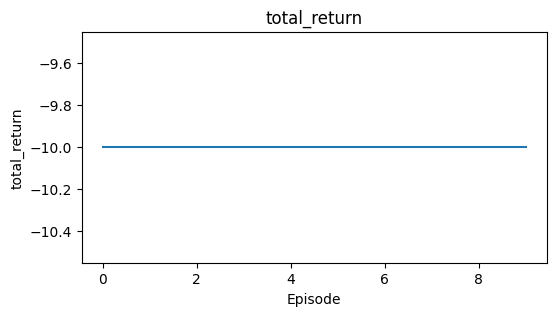

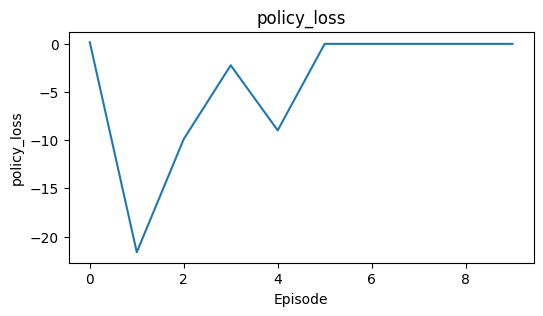

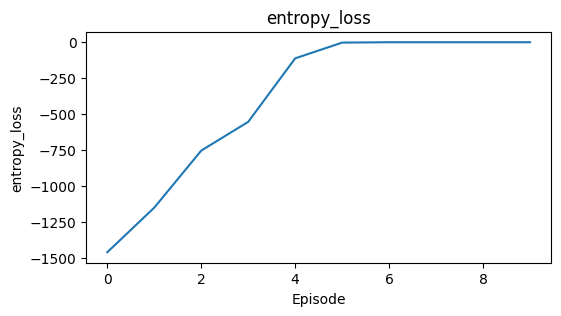

In [13]:
import matplotlib.pyplot as plt

# convert every history dict to a dataframe
import pandas as pd
df = pd.DataFrame(history)
print(df)
# {'total_return': -10.0, 'policy_loss': -7.564835071563721, 'entropy_loss': -160.30296325683594, 'total_loss': -7.580865383148193}

# make a function to plot the history
def plot_from_history(df, title, size=(6, 3)):
    plt.figure(figsize=size)
    plt.plot(df[title])
    plt.title(title)
    plt.xlabel('Episode')
    plt.ylabel(title)
    plt.show()

plot_from_history(df, 'total_return')
plot_from_history(df, 'policy_loss')
plot_from_history(df, 'entropy_loss')




In [ ]:
!mkdir -p ./ckpts/

# check if game is not set
try:
    print(game)
except:
    import sys
    sys.stderr.write("Game not set, setting to unknown")
    game = "unknown"

# save your model
torch.save(policy.model.state_dict(), f"./ckpts/model_{game}_{timestamp}.pth")